In [4]:
import pandas as pd

df_train = pd.read_csv('/content/Phishing_Email.csv')
df_test = pd.read_csv('/content/se_phishing_test_set.csv')

print(f"Training: {len(df_train)} rows")
print(f"Training columns: {df_train.columns.tolist()}")
print(f"\nTest: {len(df_test)} rows")
print(f"Test columns: {df_test.columns.tolist()}")

Training: 18650 rows
Training columns: ['Unnamed: 0', 'Email Text', 'Email Type']

Test: 150 rows
Test columns: ['email_text', 'label']


ASU PHISHING DETECTION - Training Pipeline

Device: cuda

[1/9] Loading data...
Training samples: 18631
Test samples: 150

[2/9] Generating synthetic data...
Total training: 21631

[3/9] Extracting features...

[4/9] Preparing labels...

Original Email Type values: ['Safe Email' 'Phishing Email']
After mapping: [0 1]
Label distribution: {0: 12822, 1: 8809}

Original Email Type values: ['Malicious' 'Benign']
After mapping: [1 0]
Label distribution: {0: 76, 1: 74}

Final split - Train: 17304, Val: 4327, Test: 150
Train labels: (array([0, 1]), array([10257,  7047]))
Val labels: (array([0, 1]), array([2565, 1762]))
Test labels: (array([0, 1]), array([76, 74]))

[5/9] Initializing model...

[6/9] Training...

Epoch 1/4
Loss: 0.3896 | Train Acc: 0.8112 | Val F1: 0.9725

Epoch 2/4
Loss: 0.0882 | Train Acc: 0.9760 | Val F1: 0.9767

Epoch 3/4
Loss: 0.0550 | Train Acc: 0.9825 | Val F1: 0.9761

Epoch 4/4
Loss: 0.0416 | Train Acc: 0.9872 | Val F1: 0.9789

[7/9] Evaluating...

CONFIDENCE SCORE DIAG

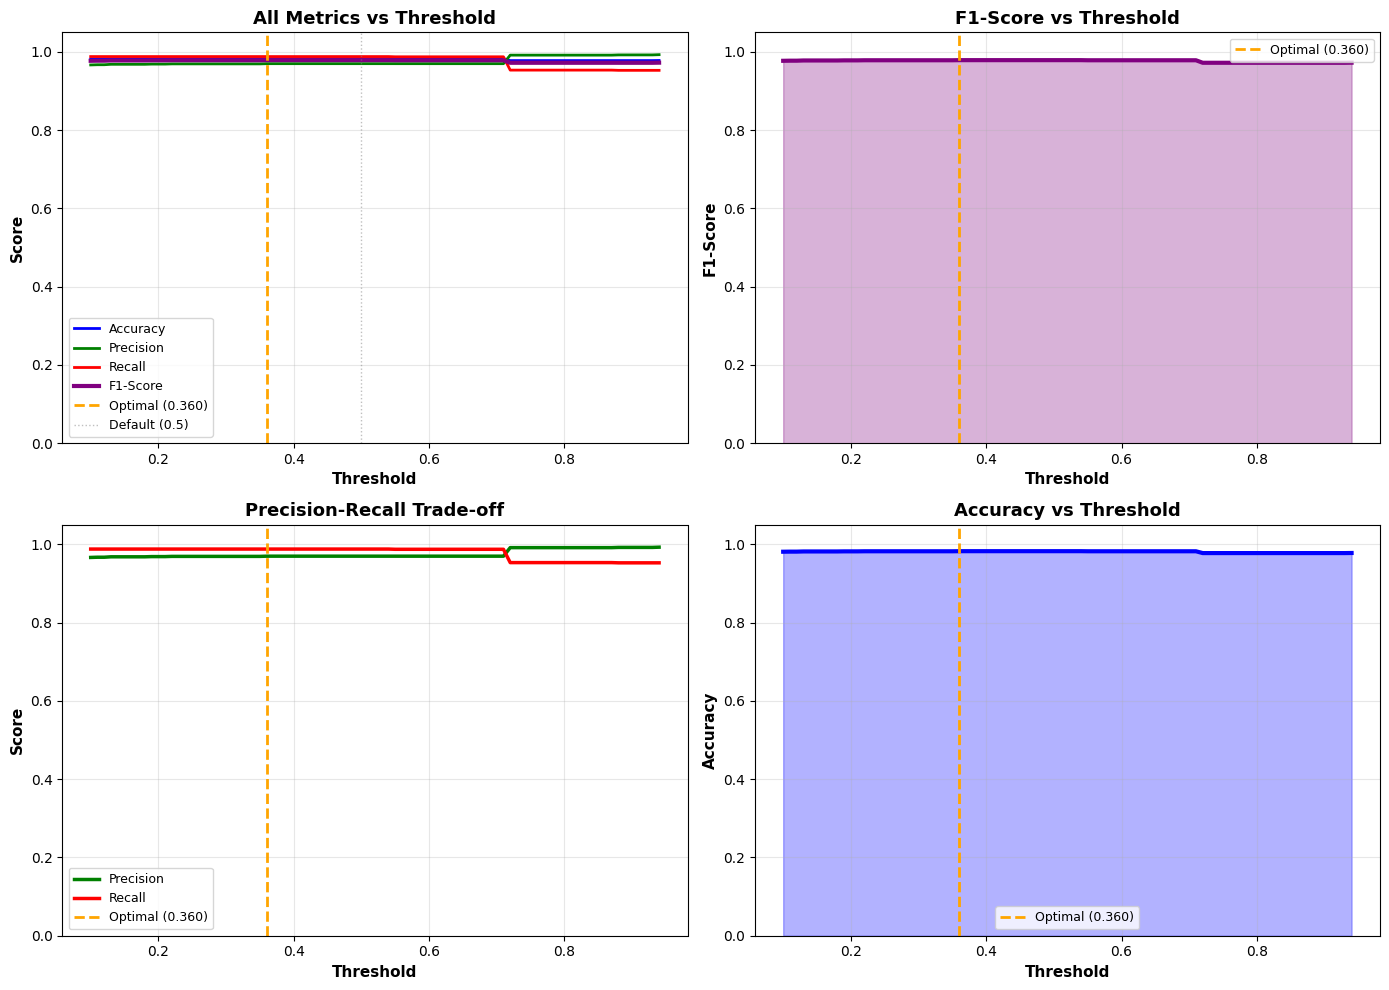

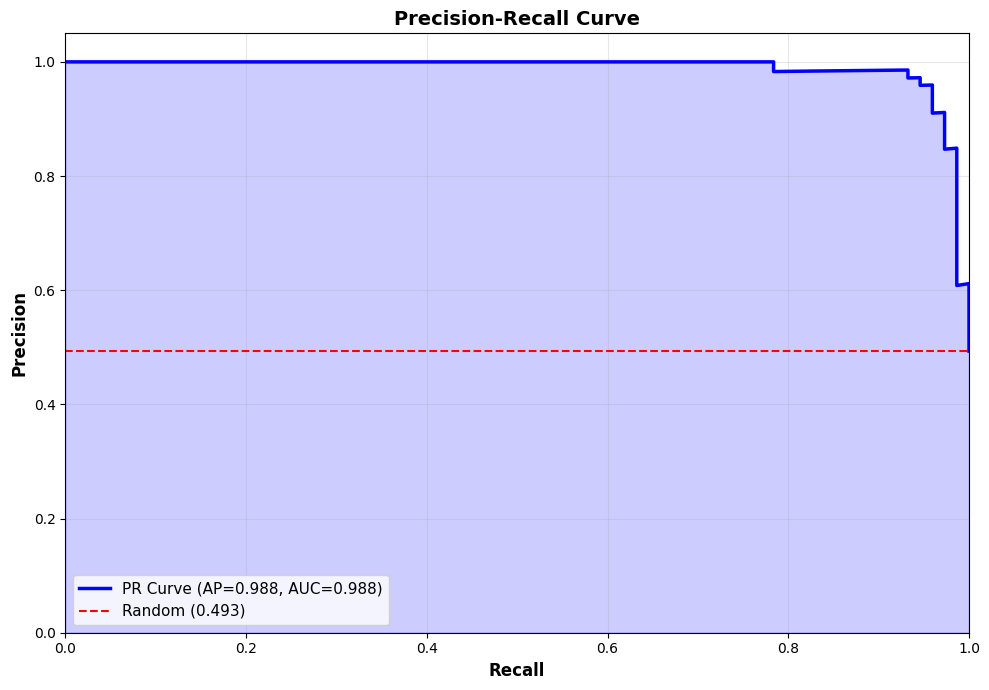

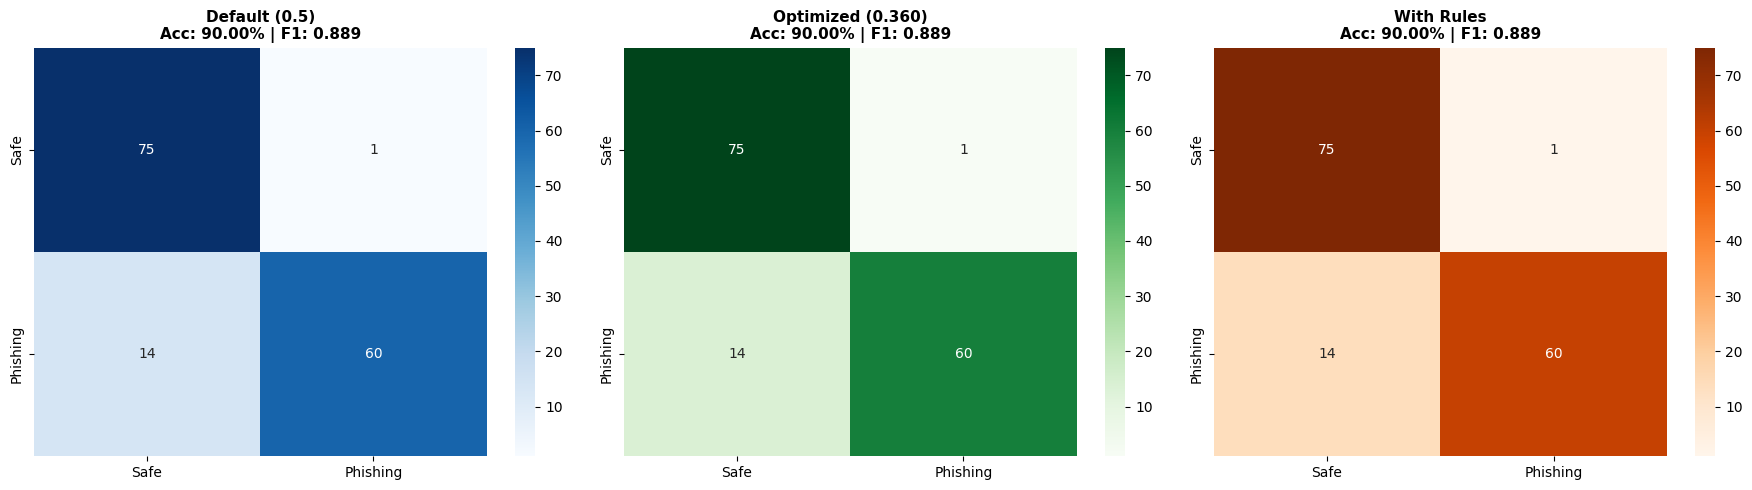

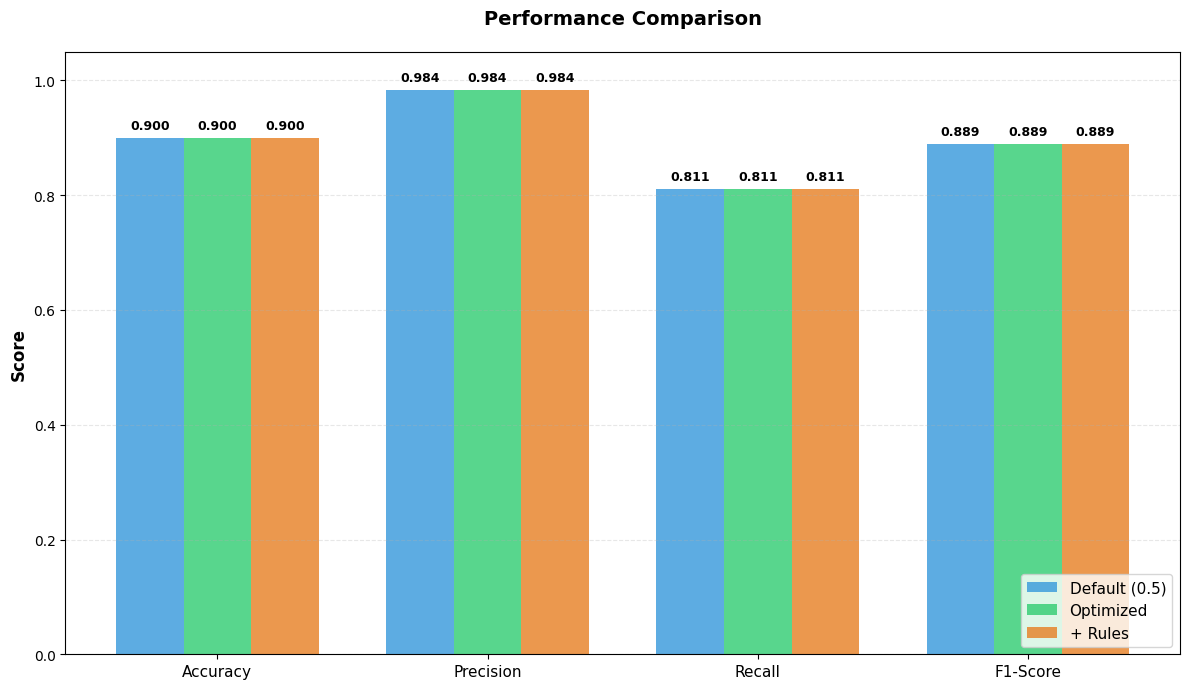

In [ ]:
"""
ASU Cyber360 Hackathon - Phishing Detection System
Hybrid Architecture: DistilBERT + 19 Engineered Features + Rule Boosting
"""

import pandas as pd
import numpy as np
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score, auc
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

class EnhancedFeatureExtractor:
    def __init__(self):
        self.urgency_words = ['urgent', 'immediately', 'asap', 'expire', 'expiring',
                              'expires', 'deadline', 'hurry', 'rush', 'quick', 'now', 'act now']
        self.threat_words = ['suspend', 'suspended', 'block', 'blocked', 'deactivate',
                            'deactivated', 'locked', 'freeze', 'frozen', 'terminate', 'close', 'disabled']
        self.action_words = ['click', 'verify', 'confirm', 'update', 'validate',
                            'authenticate', 'secure', 'restore', 'unlock', 'download']
        self.asu_legitimate_domains = ['asu.edu', 'my.asu.edu', 'students.asu.edu', 'canvas.asu.edu',
                                       'asurite.asu.edu', 'parking.asu.edu', 'housing.asu.edu']
        self.asu_fake_domains = ['asu.com', 'asu.net', 'asu.co', 'assu.edu', 'aasu.edu',
                                'arizona-state.com', 'asu-admin.com', 'my-asu.com', 'asu-verify.tk']
        self.suspicious_tlds = ['.tk', '.ml', '.ga', '.cf', '.gq', '.xyz', '.top',
                               '.click', '.pw', '.cc', '.loan', '.download', '.zip']
        self.free_email_providers = ['gmail.com', 'yahoo.com', 'hotmail.com', 'outlook.com',
                                     'aol.com', 'mail.com', 'protonmail.com', 'icloud.com']
        self.typosquatting_patterns = ['micros0ft', 'g00gle', 'paypa1', 'amaz0n', 'app1e',
                                       'assu', 'aasu', 'azsu', 'azu']
        self.sensitive_terms = ['ssn', 'social security', 'password', 'pin', 'credit card',
                               'bank account', 'routing number', 'account number']

    def extract_features(self, text, sender=''):
        if pd.isna(text) or not isinstance(text, str):
            text = ''
        text_lower = text.lower()
        features = {}

        features['urgency_count'] = sum(word in text_lower for word in self.urgency_words)
        features['threat_count'] = sum(word in text_lower for word in self.threat_words)
        features['action_count'] = sum(word in text_lower for word in self.action_words)

        url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        features['url_count'] = len(re.findall(url_pattern, text))
        features['has_url'] = 1 if features['url_count'] > 0 else 0

        obfuscated_pattern = r'h[x*]{2}p[s]?://'
        features['obfuscated_url'] = 1 if re.search(obfuscated_pattern, text_lower) else 0
        features['typosquatting'] = 1 if any(typo in text_lower for typo in self.typosquatting_patterns) else 0
        features['length'] = min(len(text) / 1000.0, 10.0)
        features['exclamation_marks'] = min(text.count('!'), 10)

        capitals = sum(1 for c in text if c.isupper())
        features['capital_ratio'] = capitals / len(text) if len(text) > 0 else 0

        asu_mentioned = any(term in text_lower for term in ['asu', 'arizona state', 'sun devil'])
        if sender and asu_mentioned:
            sender_domain = sender.split('@')[-1].lower() if '@' in sender else sender.lower()
            is_legit_asu = any(domain in sender_domain for domain in self.asu_legitimate_domains)
            features['asu_domain_mismatch'] = 1 if not is_legit_asu else 0
            is_free_provider = any(provider in sender_domain for provider in self.free_email_providers)
            features['asu_from_free_email'] = 1 if (not is_legit_asu and is_free_provider) else 0
        else:
            features['asu_domain_mismatch'] = 0
            features['asu_from_free_email'] = 0

        features['known_fake_domain'] = 1 if any(fake in text_lower for fake in self.asu_fake_domains) else 0
        features['suspicious_tld'] = 1 if any(tld in text_lower for tld in self.suspicious_tlds) else 0
        features['sensitive_info_request'] = 1 if any(term in text_lower for term in self.sensitive_terms) else 0

        ip_pattern = r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b'
        features['ip_address_url'] = 1 if re.search(ip_pattern, text) else 0
        features['urgency_threat_combo'] = 1 if (features['urgency_count'] >= 2 and features['threat_count'] >= 1) else 0

        combo_score = (features['urgency_count'] * 0.3 + features['threat_count'] * 0.3 +
                      features['action_count'] * 0.2 + features['url_count'] * 0.2)
        features['phishing_combo_score'] = min(combo_score, 5.0)

        if len(text) > 0:
            total_indicators = (features['urgency_count'] + features['threat_count'] +
                              features['action_count'] + features['url_count'])
            features['indicator_density'] = (total_indicators / len(text)) * 100
        else:
            features['indicator_density'] = 0

        return features

    def extract_batch(self, texts, senders=None):
        if senders is None:
            senders = [''] * len(texts)
        features_list = [self.extract_features(text, sender) for text, sender in zip(texts, senders)]
        return pd.DataFrame(features_list)


class EnhancedSyntheticDataGenerator:
    def __init__(self):
        self.phishing_templates = [
            "URGENT: Your {service} account will be suspended in {time}! Click {url} to verify immediately.",
            "Action Required: Unusual activity detected on your {service} account. Verify here: {url}",
            "Security Alert: Your {service} password expires {time}. Update now: {url}",
            "{service} Notice: Your account has been locked due to suspicious activity. Restore access: {url}",
            "ATTENTION ASU Students: Your ASURITE login will expire in {time}. Verify at {url}",
            "IT Security Notice: Suspicious login from {location}. If not you, secure your account: {url}",
            "Congratulations! You've won ${prize}. Claim at: {url}",
            "IT Department: Mandatory password reset required. Update here: {url}",
            "ASU Parking Services: Outstanding citation #{number}. Pay now to avoid suspension: {url}",
            "Financial Aid Alert: Verify your information to receive disbursement. Click here: {url}"
        ]

        self.safe_templates = [
            "Hi {name}, thanks for reaching out. I'll review your proposal and respond by {day}.",
            "Meeting scheduled for {day} at {time} in {location}. Agenda attached.",
            "Welcome to {service}! Here's how to get started with your new account.",
            "Your order #{number} has shipped and will arrive by {day}.",
            "Course announcement: {course} materials are now available on Canvas.",
            "Thanks for your payment of ${prize}. Your receipt is attached.",
            "Your {service} subscription renewed successfully. No action needed.",
            "System maintenance completed successfully. All services running normally.",
            "ASU Library: Your requested book is available for pickup at {location}."
        ]

        self.services = ['PayPal', 'Amazon', 'Microsoft', 'Google', 'Apple', 'Netflix',
                        'ASURITE', 'Canvas', 'My ASU']
        self.times = ['24 hours', '48 hours', '3 days', 'today']
        self.urls = ['hxxp://bit.ly/a3f2x', 'https://secure-verify.net',
                    'http://asu-verify.tk', 'https://bit.ly/sec23']
        self.names = ['John', 'Sarah', 'Mike', 'Dr. Smith']
        self.days = ['Monday', 'Tuesday', 'next week', 'tomorrow']
        self.locations = ['New York', 'Conference Room B']
        self.courses = ['CSE 110', 'MAT 265']

    def generate_phishing_email(self):
        template = np.random.choice(self.phishing_templates)
        return template.format(
            service=np.random.choice(self.services),
            time=np.random.choice(self.times),
            url=np.random.choice(self.urls),
            number=np.random.randint(1000, 9999),
            prize=np.random.randint(100, 10000),
            location=np.random.choice(self.locations),
            course=np.random.choice(self.courses)
        )

    def generate_safe_email(self):
        template = np.random.choice(self.safe_templates)
        return template.format(
            name=np.random.choice(self.names),
            day=np.random.choice(self.days),
            time=f"{np.random.randint(9, 17)}:00",
            location=np.random.choice(self.locations),
            service='our service',
            number=np.random.randint(1000, 9999),
            prize=np.random.randint(10, 500),
            course=np.random.choice(self.courses)
        )

    def generate_dataset(self, n_samples=3000):
        n_phishing = n_samples // 2
        n_safe = n_samples - n_phishing

        phishing_emails = [self.generate_phishing_email() for _ in range(n_phishing)]
        safe_emails = [self.generate_safe_email() for _ in range(n_safe)]

        df = pd.DataFrame({
            'Email Text': phishing_emails + safe_emails,
            'Email Type': ['Phishing Email'] * n_phishing + ['Safe Email'] * n_safe
        })

        return df.sample(frac=1, random_state=SEED).reset_index(drop=True)


class PhishingDataset(Dataset):
    def __init__(self, texts, features, labels, tokenizer, max_length=256):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, add_special_tokens=True, max_length=self.max_length,
            padding='max_length', truncation=True, return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'features': torch.FloatTensor(self.features[idx]),
            'label': torch.LongTensor([self.labels[idx]])
        }


class HybridPhishingDetector(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', n_features=19, dropout=0.5):
        super(HybridPhishingDetector, self).__init__()

        self.transformer = AutoModel.from_pretrained(model_name)
        transformer_dim = self.transformer.config.hidden_size

        self.feature_bn = nn.BatchNorm1d(n_features)
        self.feature_fc = nn.Sequential(
            nn.Linear(n_features, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.BatchNorm1d(128), nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(transformer_dim + 64, 512), nn.ReLU(), nn.Dropout(dropout), nn.BatchNorm1d(512),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(dropout), nn.BatchNorm1d(256),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(dropout / 2), nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, features):
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = transformer_output.last_hidden_state[:, 0, :]

        features_processed = self.feature_bn(features)
        features_processed = self.feature_fc(features_processed)

        combined = torch.cat([pooled_output, features_processed], dim=1)
        logits = self.classifier(combined)
        return logits


class ASUPhishGuard:
    def __init__(self):
        self.asu_legitimate_domains = ['asu.edu', 'my.asu.edu', 'students.asu.edu', 'canvas.asu.edu']
        self.asu_fake_domains = ['asu.com', 'asu-verify.tk', 'asu-admin.com', 'my-asu.com']
        self.suspicious_tlds = ['.tk', '.ml', '.ga', '.xyz', '.click']
        self.free_email_providers = ['gmail.com', 'yahoo.com', 'hotmail.com']

    def apply_rules(self, text, sender, base_confidence):
        boost = 0.0
        flags = []
        text_lower = text.lower()

        if sender and any(term in text_lower for term in ['asu', 'arizona state']):
            sender_domain = sender.split('@')[-1].lower() if '@' in sender else sender.lower()
            if not any(domain in sender_domain for domain in self.asu_legitimate_domains):
                boost += 15.0
                flags.append("ASU domain spoofing detected")
                if any(provider in sender_domain for provider in self.free_email_providers):
                    boost += 5.0
                    flags.append("Official ASU email from free provider")

        for fake_domain in self.asu_fake_domains:
            if fake_domain in text_lower:
                boost += 20.0
                flags.append(f"Known fake domain: {fake_domain}")
                break

        if any(tld in text_lower for tld in self.suspicious_tlds):
            boost += 10.0
            flags.append("Suspicious TLD detected")

        urgency_count = sum(1 for word in ['urgent', 'immediately', 'expire'] if word in text_lower)
        sensitive_count = sum(1 for term in ['password', 'ssn', 'credit card'] if term in text_lower)
        if urgency_count >= 2 and sensitive_count >= 1:
            boost += 12.0
            flags.append("Urgency + sensitive info request")

        boost = min(boost, 35.0)
        final_confidence = min(base_confidence + boost, 100.0)

        return {'final_confidence': final_confidence, 'rule_boost': boost, 'flags': flags}


class PhishingDetectorTrainer:
    def __init__(self, model, device, learning_rate=2e-5):
        self.model = model.to(device)
        self.device = device
        self.optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        self.criterion = nn.CrossEntropyLoss()

    def train_epoch(self, dataloader, scheduler):
        self.model.train()
        total_loss = 0
        predictions = []
        true_labels = []

        for batch in dataloader:
            self.optimizer.zero_grad()

            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            features = batch['features'].to(self.device)
            labels = batch['label'].squeeze().to(self.device)

            logits = self.model(input_ids, attention_mask, features)
            loss = self.criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        return total_loss / len(dataloader), accuracy_score(true_labels, predictions)

    def evaluate(self, dataloader):
        self.model.eval()
        predictions = []
        true_labels = []
        confidences = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                features = batch['features'].to(self.device)
                labels = batch['label'].squeeze().to(self.device)

                logits = self.model(input_ids, attention_mask, features)
                probs = torch.nn.functional.softmax(logits, dim=-1)

                predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                confidences.extend(probs[:, 1].cpu().numpy())

        accuracy = accuracy_score(true_labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

        return accuracy, precision, recall, f1, predictions, true_labels, confidences


def find_optimal_threshold(true_labels, confidences, metric='f1'):
    thresholds = np.arange(0.1, 0.95, 0.01)
    results = []

    for threshold in thresholds:
        predictions = (np.array(confidences) >= threshold).astype(int)
        acc = accuracy_score(true_labels, predictions)
        prec, rec, f1, _ = precision_recall_fscore_support(
            true_labels, predictions, average='binary', zero_division=0
        )
        balanced = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        results.append({
            'threshold': threshold, 'accuracy': acc, 'precision': prec,
            'recall': rec, 'f1': f1, 'balanced': balanced
        })

    results_df = pd.DataFrame(results)
    optimal_idx = results_df[metric].idxmax()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    metrics_dict = results_df.loc[optimal_idx].to_dict()

    return optimal_threshold, metrics_dict, results_df


def plot_threshold_analysis(results_df, optimal_threshold, save_path='threshold_analysis.png'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax = axes[0, 0]
    ax.plot(results_df['threshold'], results_df['accuracy'], 'b-', linewidth=2, label='Accuracy')
    ax.plot(results_df['threshold'], results_df['precision'], 'g-', linewidth=2, label='Precision')
    ax.plot(results_df['threshold'], results_df['recall'], 'r-', linewidth=2, label='Recall')
    ax.plot(results_df['threshold'], results_df['f1'], 'purple', linewidth=3, label='F1-Score')
    ax.axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
    ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Default (0.5)')
    ax.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title('All Metrics vs Threshold', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

    ax = axes[0, 1]
    ax.plot(results_df['threshold'], results_df['f1'], 'purple', linewidth=3)
    ax.fill_between(results_df['threshold'], results_df['f1'], alpha=0.3, color='purple')
    ax.axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
    ax.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title('F1-Score vs Threshold', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

    ax = axes[1, 0]
    ax.plot(results_df['threshold'], results_df['precision'], 'g-', linewidth=2.5, label='Precision')
    ax.plot(results_df['threshold'], results_df['recall'], 'r-', linewidth=2.5, label='Recall')
    ax.axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
    ax.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title('Precision-Recall Trade-off', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

    ax = axes[1, 1]
    ax.plot(results_df['threshold'], results_df['accuracy'], 'b-', linewidth=3)
    ax.fill_between(results_df['threshold'], results_df['accuracy'], alpha=0.3, color='blue')
    ax.axvline(x=optimal_threshold, color='orange', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
    ax.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title('Accuracy vs Threshold', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')


def plot_precision_recall_curve(true_labels, confidences, save_path='precision_recall_curve.png'):
    precision, recall, _ = precision_recall_curve(true_labels, confidences)
    avg_precision = average_precision_score(true_labels, confidences)
    pr_auc = auc(recall, precision)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(recall, precision, 'b-', linewidth=2.5, label=f'PR Curve (AP={avg_precision:.3f}, AUC={pr_auc:.3f})')
    ax.fill_between(recall, precision, alpha=0.2, color='blue')

    no_skill = sum(true_labels) / len(true_labels)
    ax.plot([0, 1], [no_skill, no_skill], 'r--', linewidth=1.5, label=f'Random ({no_skill:.3f})')

    ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')


def plot_confusion_matrices(test_true, test_preds_default, test_preds_optimal,
                           enhanced_preds, optimal_threshold, save_path='confusion_matrices.png'):
    metrics_default = precision_recall_fscore_support(test_true, test_preds_default, average='binary')
    metrics_optimal = precision_recall_fscore_support(test_true, test_preds_optimal, average='binary')
    metrics_enhanced = precision_recall_fscore_support(test_true, enhanced_preds, average='binary')

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    cm1 = confusion_matrix(test_true, test_preds_default)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
    axes[0].set_title(f'Default (0.5)\nAcc: {accuracy_score(test_true, test_preds_default)*100:.2f}% | '
                     f'F1: {metrics_default[2]:.3f}', fontsize=11, fontweight='bold')

    cm2 = confusion_matrix(test_true, test_preds_optimal)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
    axes[1].set_title(f'Optimized ({optimal_threshold:.3f})\nAcc: {accuracy_score(test_true, test_preds_optimal)*100:.2f}% | '
                     f'F1: {metrics_optimal[2]:.3f}', fontsize=11, fontweight='bold')

    cm3 = confusion_matrix(test_true, enhanced_preds)
    sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
                xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'])
    axes[2].set_title(f'With Rules\nAcc: {accuracy_score(test_true, enhanced_preds)*100:.2f}% | '
                     f'F1: {metrics_enhanced[2]:.3f}', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')


def plot_metrics_comparison(acc1, f1_1, rec1, prec1, acc2, f1_2, rec2, prec2,
                           acc3, f1_3, rec3, prec3, save_path='metrics_comparison.png'):
    fig, ax = plt.subplots(figsize=(12, 7))

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metrics))
    width = 0.25

    bars1 = ax.bar(x - width, [acc1, prec1, rec1, f1_1], width, label='Default (0.5)', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x, [acc2, prec2, rec2, f1_2], width, label='Optimized', color='#2ecc71', alpha=0.8)
    bars3 = ax.bar(x + width, [acc3, prec3, rec3, f1_3], width, label='+ Rules', color='#e67e22', alpha=0.8)

    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Performance Comparison', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=11, loc='lower right')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')


def main():
    print("=" * 80)
    print("ASU PHISHING DETECTION - Training Pipeline")
    print("=" * 80)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nDevice: {device}")

    print("\n[1/9] Loading data...")
    df_train = pd.read_csv('/content/Phishing_Email.csv')
    df_test = pd.read_csv('/content/se_phishing_test_set.csv')

    if 'email_text' in df_test.columns:
        df_test = df_test.rename(columns={'email_text': 'Email Text', 'label': 'Email Type'})

    df_train['Email Text'] = df_train['Email Text'].fillna('').astype(str)
    df_test['Email Text'] = df_test['Email Text'].fillna('').astype(str)
    df_train = df_train[df_train['Email Text'].str.strip() != '']
    df_test = df_test[df_test['Email Text'].str.strip() != '']

    print(f"Training samples: {len(df_train)}")
    print(f"Test samples: {len(df_test)}")

    print("\n[2/9] Generating synthetic data...")
    generator = EnhancedSyntheticDataGenerator()
    df_synthetic = generator.generate_dataset(n_samples=3000)
    df_train_full = pd.concat([df_train, df_synthetic], ignore_index=True).sample(frac=1, random_state=SEED)
    print(f"Total training: {len(df_train_full)}")

    print("\n[3/9] Extracting features...")
    feature_extractor = EnhancedFeatureExtractor()
    train_features = feature_extractor.extract_batch(df_train_full['Email Text'].values)
    test_features = feature_extractor.extract_batch(df_test['Email Text'].values)

    print("\n[4/9] Preparing labels...")
    for df in [df_train_full, df_test]:
        label_col = 'Email Type' if 'Email Type' in df.columns else 'label'

        print(f"\nOriginal {label_col} values: {df[label_col].unique()}")

        # Always convert to lowercase strings first
        df[label_col] = df[label_col].astype(str).str.strip().str.lower()

        # Comprehensive mapping for all possible label formats
        label_mapping = {
            'safe email': 0, 'phishing email': 1,
            'safe': 0, 'phishing': 1,
            'benign': 0, 'malicious': 1,
            'legitimate': 0, 'spam': 1,
            'ham': 0, 'phish': 1,
            '0': 0, '1': 1,
            '0.0': 0, '1.0': 1
        }

        df['label'] = df[label_col].map(label_mapping)

        # Check for unmapped values
        if df['label'].isna().any():
            unmapped = df[df['label'].isna()][label_col].unique()
            print(f"WARNING: Unmapped label values found: {unmapped}")
            print("Setting unmapped values to 0 (Safe)")
            df['label'].fillna(0, inplace=True)

        df['label'] = df['label'].astype(int)

        print(f"After mapping: {df['label'].unique()}")
        print(f"Label distribution: {df['label'].value_counts().to_dict()}")

    train_texts, val_texts, train_feat, val_feat, train_labels, val_labels = train_test_split(
        df_train_full['Email Text'].values, train_features.values, df_train_full['label'].values,
        test_size=0.2, random_state=SEED, stratify=df_train_full['label']
    )
    test_texts = df_test['Email Text'].values
    test_feat = test_features.values
    test_labels = df_test['label'].values

    print(f"\nFinal split - Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")
    print(f"Train labels: {np.unique(train_labels, return_counts=True)}")
    print(f"Val labels: {np.unique(val_labels, return_counts=True)}")
    print(f"Test labels: {np.unique(test_labels, return_counts=True)}")

    scaler = StandardScaler()
    train_feat_scaled = scaler.fit_transform(train_feat)
    val_feat_scaled = scaler.transform(val_feat)
    test_feat_scaled = scaler.transform(test_feat)

    print("\n[5/9] Initializing model...")
    MODEL_NAME = 'distilbert-base-uncased'
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = HybridPhishingDetector(model_name=MODEL_NAME, n_features=19, dropout=0.5)

    BATCH_SIZE = 16
    train_dataset = PhishingDataset(train_texts, train_feat_scaled, train_labels, tokenizer)
    val_dataset = PhishingDataset(val_texts, val_feat_scaled, val_labels, tokenizer)
    test_dataset = PhishingDataset(test_texts, test_feat_scaled, test_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    print("\n[6/9] Training...")
    EPOCHS = 4
    trainer = PhishingDetectorTrainer(model, device, learning_rate=2e-5)

    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        trainer.optimizer, num_warmup_steps=total_steps // 10, num_training_steps=total_steps
    )

    best_val_f1 = 0
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        train_loss, train_acc = trainer.train_epoch(train_loader, scheduler)
        val_acc, val_prec, val_rec, val_f1, _, _, _ = trainer.evaluate(val_loader)
        print(f"Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')

    print("\n[7/9] Evaluating...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_acc, test_prec, test_rec, test_f1, test_preds, test_true, test_conf = trainer.evaluate(test_loader)

    print("\n" + "=" * 80)
    print("CONFIDENCE SCORE DIAGNOSTICS")
    print("=" * 80)
    print(f"Min confidence: {min(test_conf):.4f}")
    print(f"Max confidence: {max(test_conf):.4f}")
    print(f"Mean confidence: {np.mean(test_conf):.4f}")
    print(f"Median confidence: {np.median(test_conf):.4f}")

    print("\nPredictions at different thresholds:")
    for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
        n_phishing = sum(1 for c in test_conf if c >= thresh)
        print(f"  Threshold {thresh:.1f}: {n_phishing}/150 predicted as phishing")

    print("\n" + "=" * 80)
    print(f"\nDefault (0.5): Acc={test_acc:.4f}, Prec={test_prec:.4f}, Rec={test_rec:.4f}, F1={test_f1:.4f}")

    print("\n[8/9] Optimizing threshold...")
    val_acc, val_prec, val_rec, val_f1, val_preds, val_true, val_conf = trainer.evaluate(val_loader)
    optimal_threshold, threshold_metrics, threshold_df = find_optimal_threshold(val_true, val_conf)

    test_preds_optimal = (np.array(test_conf) >= optimal_threshold).astype(int)
    test_acc_opt = accuracy_score(test_true, test_preds_optimal)
    test_prec_opt, test_rec_opt, test_f1_opt, _ = precision_recall_fscore_support(
        test_true, test_preds_optimal, average='binary'
    )

    print(f"Optimal ({optimal_threshold:.3f}): Acc={test_acc_opt:.4f}, Prec={test_prec_opt:.4f}, Rec={test_rec_opt:.4f}, F1={test_f1_opt:.4f}")

    print("\nTrying manual thresholds:")
    for manual_thresh in [0.1, 0.2, 0.3]:
        manual_preds = (np.array(test_conf) >= manual_thresh).astype(int)
        m_acc = accuracy_score(test_true, manual_preds)
        m_prec, m_rec, m_f1, _ = precision_recall_fscore_support(test_true, manual_preds, average='binary')
        print(f"Manual ({manual_thresh:.1f}): Acc={m_acc:.4f}, Prec={m_prec:.4f}, Rec={m_rec:.4f}, F1={m_f1:.4f}")

    guard = ASUPhishGuard()
    enhanced_preds = []
    for text, base_conf in zip(test_texts, test_conf):
        result = guard.apply_rules(text, '', base_conf * 100)
        is_phishing = 1 if result['final_confidence'] > (optimal_threshold * 100) else 0
        enhanced_preds.append(is_phishing)

    enhanced_preds = np.array(enhanced_preds)
    enhanced_acc = accuracy_score(test_true, enhanced_preds)
    enhanced_prec, enhanced_rec, enhanced_f1, _ = precision_recall_fscore_support(
        test_true, enhanced_preds, average='binary'
    )

    print(f"With Rules: Acc={enhanced_acc:.4f}, Prec={enhanced_prec:.4f}, Rec={enhanced_rec:.4f}, F1={enhanced_f1:.4f}")

    print("\n[9/9] Generating visualizations...")
    plot_threshold_analysis(threshold_df, optimal_threshold)
    plot_precision_recall_curve(test_true, test_conf)
    plot_confusion_matrices(test_true, test_preds, test_preds_optimal, enhanced_preds, optimal_threshold)
    plot_metrics_comparison(test_acc, test_f1, test_rec, test_prec,
                           test_acc_opt, test_f1_opt, test_rec_opt, test_prec_opt,
                           enhanced_acc, enhanced_f1, enhanced_rec, enhanced_prec)

    print("\n" + "=" * 80)
    print("CLASSIFICATION REPORT (Final Model)")
    print("=" * 80)
    print(classification_report(test_true, enhanced_preds, target_names=['Safe', 'Phishing']))

    results = {
        'optimal_threshold': float(optimal_threshold),
        'final_metrics': {
            'accuracy': float(enhanced_acc),
            'precision': float(enhanced_prec),
            'recall': float(enhanced_rec),
            'f1_score': float(enhanced_f1)
        }
    }

    with open('model_metadata.json', 'w') as f:
        json.dump(results, f, indent=2)

    print("\n" + "=" * 80)
    print("TRAINING COMPLETE")
    print("=" * 80)
    print(f"\nFinal Results:")
    print(f"  Accuracy: {enhanced_acc*100:.2f}%")
    print(f"  Precision: {enhanced_prec:.3f}")
    print(f"  Recall: {enhanced_rec:.3f}")
    print(f"  F1-Score: {enhanced_f1:.3f}")
    print(f"  Optimal Threshold: {optimal_threshold:.3f}")
    print("\nSaved Files:")
    print("  - best_model.pth")
    print("  - model_metadata.json")
    print("  - threshold_analysis.png")
    print("  - precision_recall_curve.png")
    print("  - confusion_matrices.png")
    print("  - metrics_comparison.png")
    print("=" * 80)


if __name__ == "__main__":
    main()